### k nearest neighbors example
Chronic kidney disease data

In [1]:
import numpy as np
from datascience import *
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', UserWarning)
from IPython.display import Image
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
import EDS
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit import DataStructs

In [2]:
url = "https://raw.githubusercontent.com/vamshikrishnajr/chronic-kidney-disease-diagnosis/master/kidney_disease.csv"
ckd_db = pd.read_csv(url)
ckd_db.dropna(axis=0,  inplace=True)
ckd_db

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
9,9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,ckd
11,11,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,...,32.0,4500.0,3.8,yes,yes,no,poor,yes,no,ckd
14,14,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,...,16.0,11000.0,2.6,yes,yes,yes,poor,yes,no,ckd
20,20,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,...,24.0,9200.0,3.2,yes,yes,yes,poor,yes,yes,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,47.0,6700.0,4.9,no,no,no,good,no,no,notckd
396,396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,54.0,7800.0,6.2,no,no,no,good,no,no,notckd
397,397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,49.0,6600.0,5.4,no,no,no,good,no,no,notckd
398,398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,51.0,7200.0,5.9,no,no,no,good,no,no,notckd


In [ ]:
ckd_db['Class'] = np.where(ckd_db['classification'] == "ckd", 1, 0)
ckd = Table().from_df(ckd_db)
ckd

In [ ]:
def standard_units(xyz):
    "Convert any array of numbers to standard units."
    return (xyz - np.mean(xyz))/np.std(xyz)  

In [ ]:
ckd_s = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('hemo')),
    'Glucose', standard_units(ckd.column('bgr')),
    'White Blood Cell Count', standard_units(ckd.column('wc')),
    'Class', (ckd.column('Class'))
)

In [ ]:
ckd_s.stats()

In [ ]:
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd_s = ckd_s.join('Class', color_table)

In [ ]:
ckd_s

In [ ]:
ckd_s.scatter('Hemoglobin', 'Glucose', group='Color')

In [ ]:
ckd_s.scatter('White Blood Cell Count', 'Glucose', group='Color')

In [ ]:
train, test = ckd_s.split(int(ckd_s.num_rows*0.8))
print(train.num_rows, 'training and', test.num_rows, 'test instances.')

In [ ]:
def distance(point1, point2):
    """Returns the Euclidean distance between point1 and point2.
    
    Each argument is an array containing the coordinates of a point."""
    return np.sqrt(np.sum((point1 - point2)**2))

In [ ]:
def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(row1), np.array(row2)) # Need to convert rows into arrays

In [ ]:
test_point_row = test.drop("Class","Color").row(9)
train_point_row = train.drop("Class","Color").row(8)

In [ ]:
np.array(train_point_row)

In [ ]:
row_distance(train_point_row,test_point_row)

In [ ]:
test.show(9)

In [ ]:
def distances(training, example, output):
    """Compute the distance from example for each row in training."""
    dists = []
    attributes = training.drop(output)
    for row in attributes.rows:
        dists.append(row_distance(row, example))
    return training.with_column('Distance', dists)

def closest(training, example, k, output):
    """Return a table of the k closest neighbors to example."""
    return distances(training, example, output).sort('Distance').take(np.arange(k))

In [ ]:
test.row(31)

In [ ]:
cl_knn = closest(train.drop("Color"), test.drop("Class","Color").row(31), 8, "Class")
cl_knn

### We can use most frequent value for the class as the prediction (like majority)

In [ ]:
print("Most frequent value in the above array:")
print(np.bincount(cl_knn.column("Class")).argmax())

### Prediction
Now lets predict across all test rows and get a % accuracy

In [ ]:
correct = 0
k = 20
for i, row in enumerate(test.drop("Color").rows):
    #print(i,row)
    cl_knn = closest(train.drop("Color"), test.drop("Class","Color").row(i), k, "Class")
    print(i," Prediction: ",np.bincount(cl_knn.column("Class")).argmax()," Actual: ",test.column("Class").take(i))
    correct += (np.bincount(cl_knn.column("Class")).argmax()==test.column("Class").take(i))
print("% Correct: ",correct/(i+1)*100)

### Machine Learning Prediction of molecular Properties

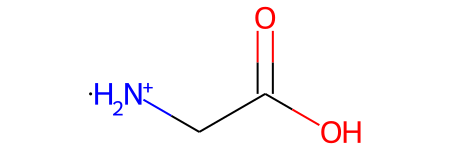

In [2]:
Chem.MolFromSmiles("[NH2+]CC(O)=O") # Glycine an amino acid

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

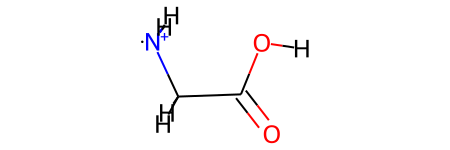

In [3]:
EDS.smiles3D("[NH2+]CC(O)=O")